In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from pathlib import Path
from shapely import from_wkt
import pedpy
import json

../trajectories_croma/1C060_cam6_cam5_frameshift0_Combined.txt
frame_after_decrease = 3951


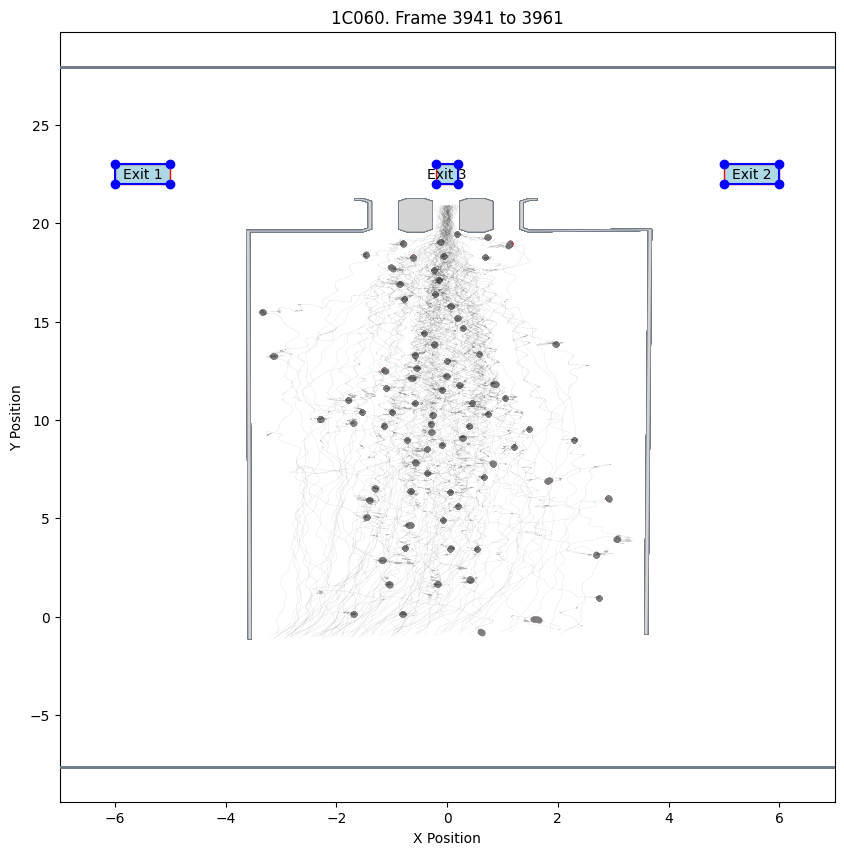

In [71]:
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data


def get_first_frame_after_max_reached(filename):
    """Return the first frame after the number of pedestrians starts decreasing from max_ids."""
    df = pd.read_csv(
        filename, sep="\t", names=["id", "frame", "x", "y", "z", "m"], comment="#"
    )
    frames = np.unique(df["frame"])
    ids = np.unique(df["id"])
    max_ids = len(ids) - 2  # I don't knnow why 2 are missing
    max_reached = False

    for frame in range(frames.min(), frames.max() + 1):
        frame_data = df[df["frame"] == frame]
        count_in_frame = frame_data["id"].nunique()
        if count_in_frame >= max_ids:
            max_reached = True
            return df, frame - 1

        # Once max_ids has been reached, check if the number of pedestrians decreases
        if max_reached and count_in_frame == max_ids - 1:
            return df, frame - 1

    return pd.DataFrame(), None

def plot_trajectories_around_frame(
    df, target_frame, num_frames=10, title="", geometry=None, inifile='files/inifile.json'
):
    """Plot trajectories for num_frames before and after the target frame."""
    # Calculate the frame range
    start_frame = max(target_frame - num_frames, df["frame"].min())
    end_frame = min(target_frame + num_frames, df["frame"].max())
    filtered_df = df[(df["frame"] >= start_frame) & (df["frame"] <= end_frame)]
    # Create a figure
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    ids = np.unique(filtered_df["id"])
    for ped in ids:
        ped_data = df[df["id"] == ped]
        for frame in range(start_frame, end_frame + 1):
            color = "gray" if frame != target_frame else "red"
            frame_data = ped_data[ped_data["frame"] == frame]
            if not frame_data.empty:
                plt.plot(
                    frame_data["x"],
                    frame_data["y"],
                    ".",
                    color=color,
                    label=f"Ped {ped} at frame {frame}",
                )

        plt.plot(
            ped_data["x"],
            ped_data["y"],
            label=f"Ped {ped}",
            color="black",
            alpha=0.3,
            lw=0.1,
        )
        walkable_area = pedpy.WalkableArea(geometry)
        pedpy.plot_walkable_area(walkable_area=walkable_area)

    # plot destinations
    data = read_json_file(inifile)
    for destination in data["destinations"]:
        vertices = destination["vertices"]
        polygon = plt.Polygon(vertices, closed=True, fill=True, edgecolor='r', facecolor='lightblue', label=f"Exit {destination['id']}")
        plt.gca().add_patch(polygon)
        plt.plot(*zip(*vertices), marker='o', color='b')
        centroid = [sum(x)/len(vertices) for x in zip(*vertices)]
        plt.text(centroid[0], centroid[1], f"{destination['id']}", ha='center', va='center', fontsize=10, color='black')

    plt.xlim(-7, 7)
    # Add labels and title
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title(f"{title}. Frame {start_frame} to {end_frame}")
    plt.savefig(f"{title}_frame_{start_frame}_to_{end_frame}.png")
    plt.show()


filenames = [
    "../trajectories_croma/1C060_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/1C070_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/2C070_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/2C120_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/2C130_cam6_cam5_frameshift0_Combined.txt",
    "../trajectories_croma/2C150_cam6_cam5_frameshift0_Combined.txt",
]


# Define the WKT string for the polygon
geometry = from_wkt(
    "POLYGON ((-8.88 -7.63, 8.3 -7.63, 8.3 27.95, -8.88 27.95, -8.88 -7.63), (-3.54 -1.13, -3.57 19.57, -1.52 19.57, -1.37 19.71, -1.37 21.09, -1.52 21.23, -1.67 21.23, -1.67 21.18, -1.545 21.18, -1.4200000000000002 21.065, -1.4200000000000002 19.735, -1.545 19.62, -3.6199999999999997 19.62, -3.59 -1.13, -3.54 -1.13), (3.57 -0.89, 3.64 19.64, 1.47 19.57, 1.32 19.71, 1.32 21.09, 1.47 21.23, 1.62 21.23, 1.62 21.18, 1.4949999999999999 21.18, 1.37 21.065, 1.37 19.735, 1.4949999999999999 19.62, 3.69 19.69, 3.6199999999999997 -0.89, 3.57 -0.89), (0.67 19.57, 0.82 19.71, 0.82 21.09, 0.67 21.23, 0.38 21.23, 0.23 21.09, 0.23 19.71, 0.38 19.57, 0.67 19.57), (-0.42 19.57, -0.27 19.71, -0.27 21.09, -0.42 21.23, -0.72 21.23, -0.87 21.09, -0.87 19.71, -0.72 19.57, -0.42 19.57))"
)
for filename in filenames[0:1]:
    df, frame_after_decrease = get_first_frame_after_max_reached(filename)
    print(f"{filename}")
    print(f"{frame_after_decrease = }")
    title = Path(filename).stem.split("_")[0]

    if frame_after_decrease is not None:
        frame_data = df[df["frame"] == frame_after_decrease]
        tuple_list = [tuple(x) for x in frame_data[['x', 'y']].to_numpy()]
        filename = f"{title}_frame_{frame_after_decrease}.csv"
        with open(filename, 'w') as f:
            writer = csv.writer(f)
            writer.writerows(tuple_list)
        plot_trajectories_around_frame(
            df, frame_after_decrease, num_frames=10, title=title, geometry=geometry
        )
    else:
        print("No valid frame found for visualization.")


# plot exits
        


In [4]:
def write_result_to_csv(filename="points.csv"):
    frame_data = df[df["frame"] == frame_after_decrease]
    tuple_list = [tuple(x) for x in frame_data[["x", "y"]].to_numpy()]
    frame_data = df[df["frame"] == frame_after_decrease]
    tuple_list = [tuple(x) for x in frame_data[["x", "y"]].to_numpy()]
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(tuple_list)